**HW1, report, Dinar Sharafutdinov**

Here is my report where I show the solution step by step and explain problems that I've faced

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
from copy import deepcopy
import json
import os
import warnings
import glob
import re
from io import StringIO, BytesIO
from functools import partial
from typing import Tuple

import h5py
import k3d
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

In [3]:
import sys
sys.path.append('..')

In [4]:
from gcv_v20211_hw1.utils.plotting import display_depth_sharpness, display_sharpness
from gcv_v20211_hw1.utils.hdf5.dataset import Hdf5File, PreloadTypes
from gcv_v20211_hw1.utils.sharpf_io import WholeDepthMapIO, PointPatchPredictionsIO
from gcv_v20211_hw1.utils.camera_utils.camera_pose import camera_to_display, CameraPose

### Data preparation

In [15]:
ground_truth_dataset = Hdf5File(
    '../validation/med_res/abc_0050_00500149_54930d6f7740b03347d89a56_000.hdf5',
    io=WholeDepthMapIO,
    preload=PreloadTypes.LAZY,
    labels='*')

predictions_dataset = Hdf5File(
    '../validation/med_res/abc_0050_00500149_54930d6f7740b03347d89a56_000__predictions.hdf5',
    io=WholeDepthMapIO,
    preload=PreloadTypes.LAZY,
    labels='*')

..\gcv_v20211_hw1\utils\hdf5\dataset.py:64: UserWarning: File C:\Users\dinar\YandexDisk\skoltech-gcv-course-2021-main\skoltech-gcv-course-2021-main\HW1\gcv_v2021.1_hw1\gcv_v2021.1_hw1\validation\med_res\abc_0050_00500149_54930d6f7740b03347d89a56_000__predictions.hdf5 is not compatible with Hdf5File I/O interface <class 'gcv_v20211_hw1.utils.hdf5.io_struct.HDF5IO'>
  warnings.warn('File {} is not compatible with Hdf5File I/O interface {}'.format(


In [16]:
def distances_nobg(distances, image):
    # here we take distances for image pixels
    distances_ = np.zeros_like(distances)
    distances_[np.nonzero(image)] = distances[np.nonzero(image)]
    return distances_

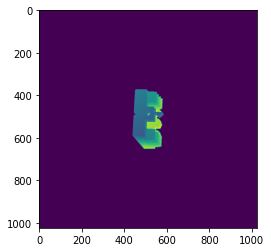

In [7]:
plt.imshow(ground_truth_dataset[0]['image'])

..\gcv_v20211_hw1\utils\plotting.py:132: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  depth_cmap.set_bad(color='black')
..\gcv_v20211_hw1\utils\plotting.py:148: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm_r"))
  sharpness_cmap.set_bad(color='black')


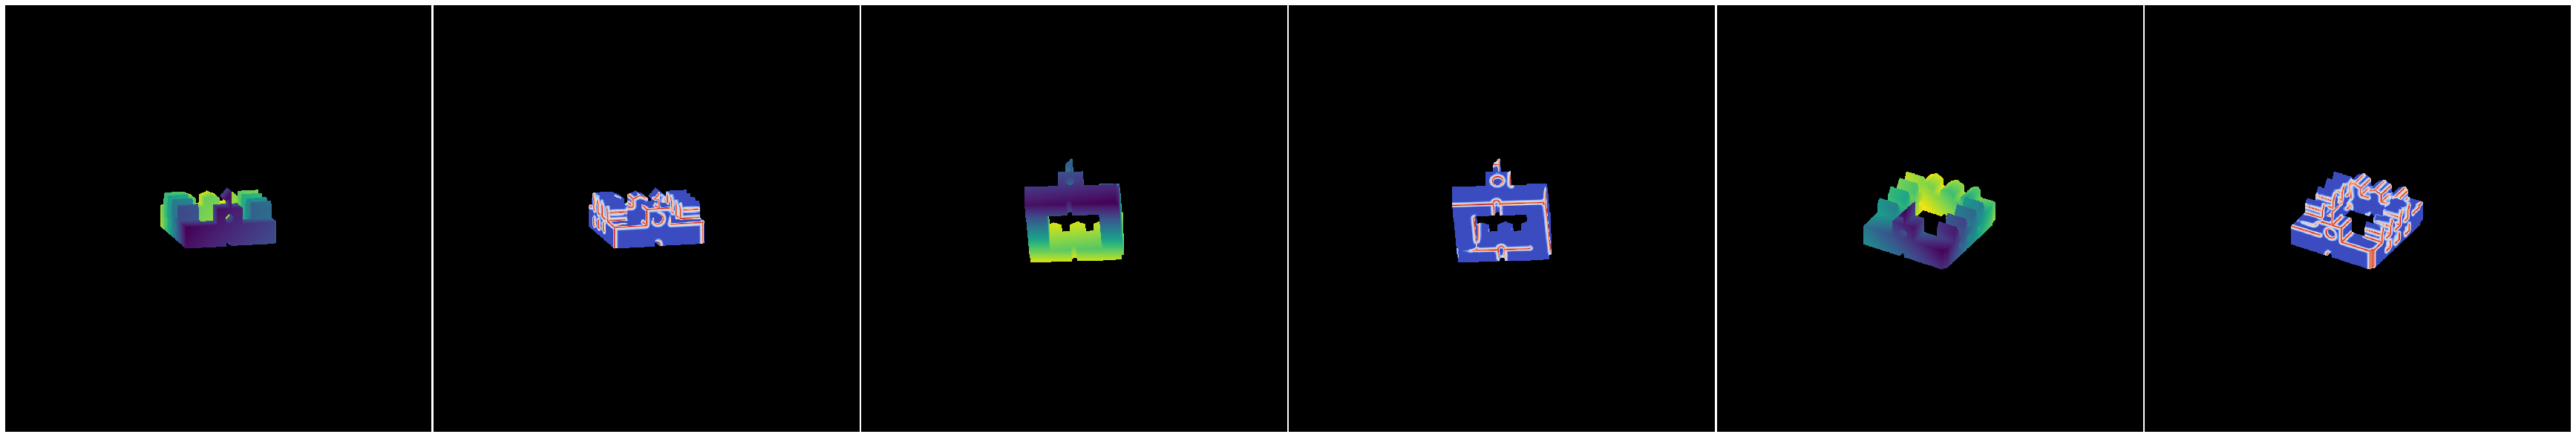

In [21]:
display_depth_sharpness(
    depth_images=[
        camera_to_display(ground_truth_dataset[0]['image']), # camera_to_display just inver image in some way
        camera_to_display(ground_truth_dataset[1]['image']),
        camera_to_display(ground_truth_dataset[2]['image']),
    ],
    sharpness_images=[
        camera_to_display(
            distances_nobg(predictions_dataset[0]['distances'], 
                           ground_truth_dataset[0]['image'])),
        camera_to_display(
            distances_nobg(predictions_dataset[1]['distances'], 
                           ground_truth_dataset[1]['image'])),
        camera_to_display(
            distances_nobg(predictions_dataset[2]['distances'], 
                           ground_truth_dataset[2]['image']))
    ],
    axes_size=(8, 8),
    ncols=3)

In [39]:
predictions_dataset.items['distances'].shape

(18, 1024, 1024)

In [21]:
MED_RES = 0.05
resolution_3d = MED_RES
nn_set_size = 4
distance_interpolation_threshold = 1.0

In [22]:
images = [view['image'] for view in ground_truth_dataset]
resolution_image = images[0].shape

distances = [view.get('distances', np.ones_like(view['image'])) for view in ground_truth_dataset]
extrinsics = [view['camera_pose'] for view in ground_truth_dataset]
intrinsics = [dict(resolution_image=resolution_image, resolution_3d=resolution_3d) for view in ground_truth_dataset]

In [25]:
i = 0

image_i = images[i]  # [h, w]
distances_image_i = distances[i]  # [h, w]
# Kill background for nicer visuals
distances_i = np.zeros_like(distances_image_i)
distances_i[np.nonzero(image_i)] = distances_image_i[np.nonzero(image_i)]

Here I start to code a standard algorithm

### get_view function

In [26]:
# TODO: write your code to constrict a world-frame point cloud from a depth image,
#  using known intrinsic and extrinsic camera parameters.
#  Hints: use the class `RaycastingImaging` to transform image to  points in camera frame,
#  use the class `CameraPose` to transform image to points in world frame.

I use CameraPose and RaycastingImaging classes

In [27]:
pose_i = CameraPose(extrinsics[i])

In [29]:
from gcv_v20211_hw1.utils.camera_utils.imaging import RaycastingImaging
imaging_i = RaycastingImaging(resolution_image, resolution_3d)

In [30]:
points_i = imaging_i.image_to_points(image_i)
points_i = pose_i.camera_to_world(points_i)
points_i.shape

(33172, 3)

In [31]:
def get_view(
        images,
        distances,
        extrinsics,
        intrinsics_dict,
        i):
    """A helper function to conveniently prepare view information."""
    image_i = images[i]  # [h, w]
    distances_image_i = distances[i]  # [h, w]
    # Kill background for nicer visuals
    distances_i = np.zeros_like(distances_image_i)
    distances_i[np.nonzero(image_i)] = distances_image_i[np.nonzero(image_i)]

    # TODO: write your code to constrict a world-frame point cloud from a depth image,
    #  using known intrinsic and extrinsic camera parameters.
    #  Hints: use the class `RaycastingImaging` to transform image to  points in camera frame,
    #  use the class `CameraPose` to transform image to points in world frame.
    pose_i = CameraPose(extrinsics[i]) #np.linalg.inv
    imaging_i = RaycastingImaging(resolution_image, resolution_3d)
    points_i = imaging_i.image_to_points(image_i)
    points_i = pose_i.camera_to_world(points_i)

    return image_i, distances_i, points_i, pose_i, imaging_i

In [68]:
image_i, distances_i, points_i, pose_i, imaging_i = get_view(images, distances, extrinsics, intrinsics, 0)
_, distances_j, points_j, _, _ = get_view(images, distances, extrinsics, intrinsics, 15)

distances_i_flattened = distances_i.flatten()
image_i_flattened = image_i.flatten()

In [33]:
points_i, points_j

(array([[ 5.68139489, -5.8212478 , -2.01188343],
        [ 5.68139489, -5.8212478 , -1.96060366],
        [ 5.68139489, -5.8212478 , -1.9093239 ],
        ...,
        [-5.56875537,  6.26020368,  0.47286295],
        [-5.56875537,  6.26020368,  0.52414272],
        [-5.56875537,  6.26020368,  0.57542248]]),
 array([[-5.51466826,  6.26375631, -2.01046016],
        [-5.51466826,  6.26375631, -1.95460441],
        [-5.51466826,  6.26375631, -1.89874866],
        ...,
        [ 5.42044164, -6.22317277,  0.4909383 ],
        [ 5.42044164, -6.22317277,  0.54679405],
        [ 5.42044164, -6.22317277,  0.60264979]]))

Some visualisation for check

In [109]:
plot = k3d.plot(name='points')
plot += k3d.points(points_j)
plot += k3d.points(points_i)
plot.display()

Output()

In [34]:
reprojected_j = pose_i.world_to_camera(points_j)
reprojected_i = pose_i.world_to_camera(points_i)

In [111]:
plot = k3d.plot(name='points')
plot += k3d.points(points_i)
plot += k3d.points(reprojected_j)
plot.display()

Output()

In [35]:
im = RaycastingImaging(resolution_image, resolution_3d)
p = im.image_to_points(images[0])

In [36]:
plot = k3d.plot(name='points')
plot += k3d.points(p)
plot += k3d.points(reprojected_j)
plot.display()

Output()

### Interpolation

In [ ]:
# For each reprojected point, find K nearest points in view_i,
# that are source points/pixels to interpolate from.
# We do this using imaging_i.rays_origins because these
# define (u, v) coordinates of points_i in the pixel grid of view_i.
# TODO: your code here: use cKDTree to find k=`nn_set_size` indexes of
#  nearest points for each of points from `reprojected_j`

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.query.html#scipy.spatial.cKDTree.query
https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.html

In [37]:
from scipy.spatial import cKDTree

In [39]:
uv_i = imaging_i.rays_origins[:, :2]
uv_i

array([[ 25.6 ,  25.6 ],
       [ 25.6 ,  25.55],
       [ 25.6 ,  25.5 ],
       ...,
       [-25.55, -25.45],
       [-25.55, -25.5 ],
       [-25.55, -25.55]])

In [40]:
reprojected_j

array([[-6.89849329,  0.91759927, 17.53170197],
       [-6.89849329,  0.86313749, 17.51930121],
       [-6.89849329,  0.8086757 , 17.50690044],
       ...,
       [ 6.79713646,  0.56047288,  7.83328935],
       [ 6.79713646,  0.5060111 ,  7.82088859],
       [ 6.79713646,  0.45154932,  7.80848782]])

In [41]:
 _, nn_indexes_in_i = cKDTree(uv_i).query(reprojected_j[:, :2], nn_set_size)
nn_indexes_in_i

array([[666094, 666093, 665070, 667118],
       [666095, 666094, 665071, 667119],
       [666096, 666095, 665072, 667120],
       ...,
       [385525, 385524, 386549, 384501],
       [385526, 385525, 386550, 384502],
       [385527, 386551, 385526, 385528]], dtype=int64)

In [42]:
# Create interpolation mask: True for points which
# can be stably interpolated (i.e. they have K neighbours present
# within a predefined radius).
interp_mask = np.zeros(len(reprojected_j)).astype(bool)
# Distances to be produces as output.
distances_j_interp = np.zeros(len(points_j), dtype=float)

In [43]:
interp_mask.shape

(45929,)

In [47]:
for idx, point_from_j in enumerate(reprojected_j[:1, :]):
    point_nn_indexes = nn_indexes_in_i[idx]
    # Build an [n, 3] array of XYZ coordinates for each reprojected point by taking
    # UV values from pixel grid and Z value from depth image.
    # TODO: your code here: use `point_nn_indexes` found previously
    #  and distance values from `image_i` indexed by the same `point_nn_indexes`
    point_from_j_nns = np.concatenate((uv_i[point_nn_indexes], image_i.flatten()[point_nn_indexes].reshape(-1, 1)), axis=1)

In [50]:
np.concatenate((uv_i[point_nn_indexes], image_i_flattened[point_nn_indexes].reshape(-1, 1)), axis=1)

array([[-6.9       ,  0.9       , 17.12951003],
       [-6.9       ,  0.95      , 17.14089487],
       [-6.85      ,  0.9       , 16.92967293],
       [-6.95      ,  0.9       , 17.51037774]])

In [51]:
point_from_j

array([-6.89849329,  0.91759927, 17.53170197])

In [52]:
point_from_j_nns

array([[-6.9       ,  0.9       , 17.12951003],
       [-6.9       ,  0.95      , 17.14089487],
       [-6.85      ,  0.9       , 16.92967293],
       [-6.95      ,  0.9       , 17.51037774]])

In [55]:
# TODO: compute a flag indicating the possibility to interpolate
#  by checking distance between `point_from_j` and its `point_from_j_nns`
#  against the value of `distance_interpolation_threshold`
distances_to_nearest = np.sqrt(np.sum((point_from_j - point_from_j_nns)**2, axis=1))
interp_mask[idx] = np.all(distances_to_nearest < distance_interpolation_threshold)

In [57]:
from scipy import interpolate

# TODO: your code here: use `interpolate.interp2d`
#  to construct a bilinear interpolator from distances predicted
#  in `view_i` (i.e. `distances_i`) into the point in `view_j`.
#  Use the interpolator to compute an interpolated distance value.
interpolator = interpolate.interp2d(uv_i[:, 0][point_nn_indexes], uv_i[:, 1][point_nn_indexes], distances_i_flattened[point_nn_indexes])
# distances_j_interp[idx] = ...

C:\Users\dinar\Anaconda3\envs\test\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning: The required storage space exceeds the available storage space.
Probable causes: nxest or nyest too small or s is too small. (fp>s)
	kx,ky=1,1 nx,ny=4,4 m=4 fp=0.000668 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [71]:
distances_i_flattened[point_nn_indexes]

array([0.111214  , 0.05993421, 0.15558059, 0.00355248])

In [59]:
interpolator(point_from_j[0], point_from_j[1])

array([0.08097661])

#### (Bonus task, 2 points) Here I implemented the second method (https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.bisplrep.html).

In [87]:
tck = interpolate.bisplrep(point_from_j_nns[:, 0], point_from_j_nns[:, 1], distances_i.flatten()[point_nn_indexes], kx=1, ky=1)
znew = interpolate.bisplev(point_from_j[0], point_from_j[1], tck)
znew

0.08097661340292042

 High res data fused with this approach. There are two files interpolators and interpolators_2. The second one with bisplrep interpolator

### Scripts

You can find bash script run_fin.sh with running commands for all data. Also here are the cells for each data set

med_res

In [46]:
!python ../scripts/fuse_images.py -t ../validation/med_res/abc_0050_00500082_4cb4bf14428fe3832dd7ed78_000.hdf5 -p ../validation/med_res/abc_0050_00500082_4cb4bf14428fe3832dd7ed78_000__predictions.hdf5 -o "../results" -r 0.05

^C


In [ ]:
!python ../scripts/fuse_images.py -t ../validation/med_res/abc_0050_00500149_54930d6f7740b03347d89a56_000.hdf5 -p ../validation/med_res/abc_0050_00500149_54930d6f7740b03347d89a56_000__predictions.hdf5 -o "../results" -r 0.05

In [ ]:
!python ../scripts/fuse_images.py -t ../validation/med_res/abc_0050_00500166_5894bbd701b2bb0fc88a6978_007.hdf5 -p ../validation/med_res/abc_0050_00500166_5894bbd701b2bb0fc88a6978_007__predictions.hdf5 -o "../results" -r 0.05

In [ ]:
!python ../scripts/fuse_images.py -t ../validation/med_res/abc_0050_00500348_fae0ecd8b3dc068d39f0d09c_000.hdf5 -p ../validation/med_res/abc_0050_00500348_fae0ecd8b3dc068d39f0d09c_000__predictions.hdf5 -o "../results" -r 0.05

In [ ]:
!python ../scripts/fuse_images.py -t ../validation/med_res/abc_0050_00500683_511f7debb63f164003339dec_000.hdf5 -p ../validation/med_res/abc_0050_00500683_511f7debb63f164003339dec_000__predictions.hdf5 -o "../results" -r 0.05

high_res

In [276]:
!python3 ../scripts/fuse_images.py -t ../validation/high_res/abc_0050_00500166_5894bbd701b2bb0fc88a6978_007.hdf5 -p ../validation/high_res/abc_0050_00500166_5894bbd701b2bb0fc88a6978_007__predictions.hdf5 -o "results_high" -r 0.02

^C


In [ ]:
!python3 ../scripts/fuse_images.py -t ../validation/high_res/abc_0050_00500348_fae0ecd8b3dc068d39f0d09c_000.hdf5 -p ../validation/high_res/abc_0050_00500348_fae0ecd8b3dc068d39f0d09c_000__predictions.hdf5 -o "results_high" -r 0.02

### Results

Example with visualisation

In [18]:
fused_gt_dataset = Hdf5File(
    '../results/abc_0050_00500149_54930d6f7740b03347d89a56_000__ground_truth.hdf5',
    io=PointPatchPredictionsIO,
    preload=PreloadTypes.LAZY,
    labels='*')

fused_pred_dataset = Hdf5File(
    '../results/abc_0050_00500149_54930d6f7740b03347d89a56_000__interpolated.hdf5',
    io=PointPatchPredictionsIO,
    preload=PreloadTypes.LAZY,
    labels='*')

In [15]:
fused_gt_dataset = Hdf5File(
    '../results_high/abc_0050_00500166_5894bbd701b2bb0fc88a6978_007__ground_truth.hdf5',
    io=PointPatchPredictionsIO,
    preload=PreloadTypes.LAZY,
    labels='*')

fused_pred_dataset = Hdf5File(
    '../results_high/abc_0050_00500166_5894bbd701b2bb0fc88a6978_007__interpolated.hdf5',
    io=PointPatchPredictionsIO,
    preload=PreloadTypes.LAZY,
    labels='*')

In [19]:
display_sharpness(
    samples=fused_gt_dataset[0]['points'],
    samples_distances=fused_pred_dataset[0]['distances']
)

Output()

In [20]:
plot = k3d.plot(name='points')
plot += k3d.points(fused_gt_dataset[0]['points'])
plot.display()

Output()

In [40]:
names = glob.glob('../images/*.jpg')
names

med_res

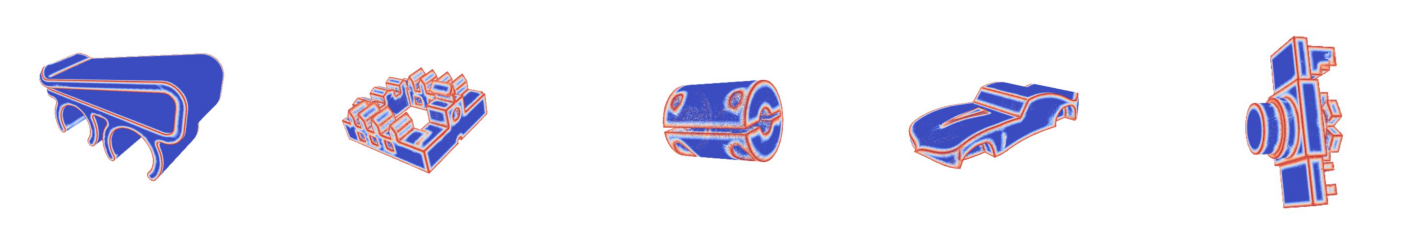

In [42]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

f, axarr = plt.subplots(1, 5, figsize=(25,25))

for i in range(5):
    axarr[i].imshow(mpimg.imread(names[i]))
    axarr[i].axis('off')

high_res

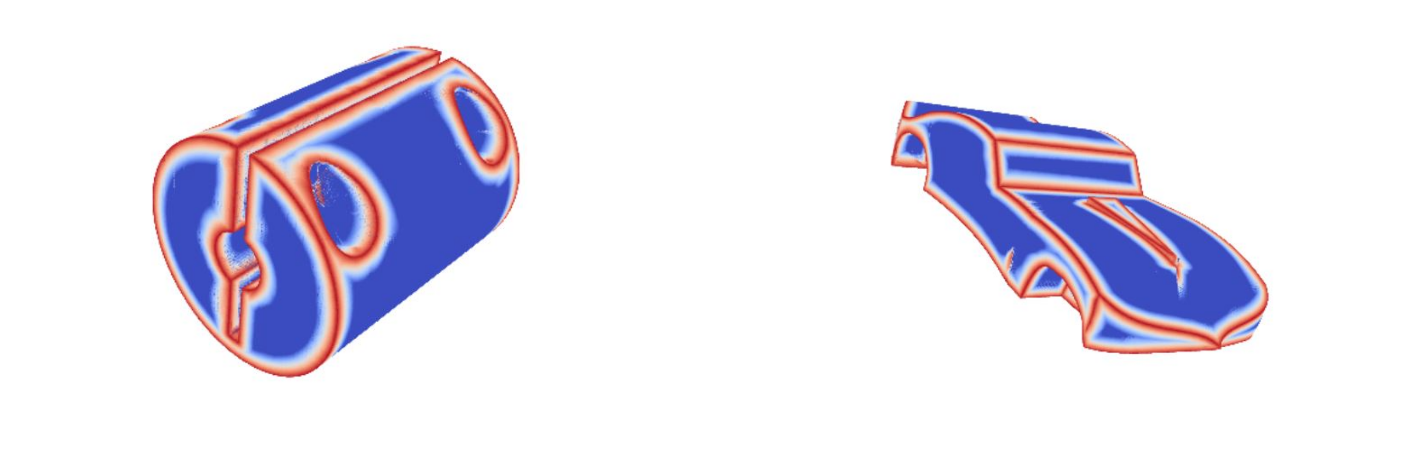

In [44]:
f, axarr = plt.subplots(1,2, figsize=(25,25))

for i in range(2):
    axarr[i].imshow(mpimg.imread(names[5+i]))
    axarr[i].axis('off')

### Conclusions and notes

As we can see the results are quite good. I don't really see the difference between the two types of interpolation but during the interpolation process indeed there was no warning as in interp2d version. Also, we see that her_res results a more detailed which is reasonable

During the work I faced a problem with performance:
- Overall fusion process was very slow. In the beginning, it took around 40 hours on my laptop and 5 hours on collab for each data file. But then I realised that there is a problem with .flatten(0 operation inside the loop which I could use beforehand. It allowed increasing performance dramatically, to one hour in collab. 


I couldn't upload results to the github, so here is a link to the cloud storage: https://yadi.sk/d/ftaT8HD5iG-EzQ